In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import tensorflow as tf

import os
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



In [ ]:
STOCKS = [
    "AAPL", "GOOGL", "MSFT", "AMZN", "TSLA",
    "NVDA", "META", "NFLX", "ADBE", "INTC"
]

print(f" Configured for {len(STOCKS)} stocks: {STOCKS}")

 Configured for 10 stocks: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA', 'META', 'NFLX', 'ADBE', 'INTC']


In [ ]:
import os
import pandas as pd

# Google Drive data folder (edit only if yours is different)
DATA_FOLDER = "/content/drive/MyDrive/data"

print("Data folder:", DATA_FOLDER)
print("CSV files found:", [f for f in os.listdir(DATA_FOLDER) if f.lower().endswith(".csv")])

def load_stock_data(symbol, data_folder=DATA_FOLDER):
    """
    Load local CSV for a stock symbol from Google Drive data folder.
    Expects: Date, Open, High, Low, Close, Volume
    """
    filepath = os.path.join(data_folder, f"{symbol}.csv")

    if not os.path.exists(filepath):
        print(f" File not found: {filepath}")
        return pd.DataFrame()

    df = pd.read_csv(filepath, parse_dates=["Date"])

    # Clean and format
    df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    df = df.sort_values("Date").reset_index(drop=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    print(f"✔ Loaded {len(df)} rows for {symbol} from {filepath}")
    return df

# Test loading one stock
test_df = load_stock_data("AAPL")
print("Sample data shape:", test_df.shape)
test_df.head()


Data folder: /content/drive/MyDrive/data
CSV files found: ['AAPL.csv', 'GOOGL.csv', 'MSFT.csv', 'AMZN.csv', 'TSLA.csv', 'NVDA.csv', 'META.csv', 'NFLX.csv', 'ADBE.csv', 'INTC.csv']
✔ Loaded 2693 rows for AAPL from /content/drive/MyDrive/data/AAPL.csv
Sample data shape: (2693, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.718174,24.729270,23.821672,24.261047,212818400
2015-01-05,24.030258,24.110144,23.391167,23.577568,257142000
2015-01-06,23.641929,23.839426,23.218087,23.579796,263188400
2015-01-07,23.788384,24.010290,23.677430,23.910433,160423600
2015-01-08,24.238861,24.886828,24.121249,24.829132,237458000


In [ ]:
def create_advanced_features(df):
    """Enhanced feature engineering based on 79% accuracy methodology"""
    df = df.copy()

    # Multi-timeframe price features
    periods = [3, 5, 7, 10, 15, 20, 30, 50]
    for period in periods:
        df[f'Return_{period}d'] = df['Close'].pct_change(period)
        df[f'MA_{period}'] = df['Close'].rolling(period).mean()
        df[f'MA_Ratio_{period}'] = df['Close'] / df[f'MA_{period}'] - 1

    # Volatility features (crucial for high accuracy)
    df['Vol_5d'] = df['Close'].pct_change().rolling(5).std()
    df['Vol_20d'] = df['Close'].pct_change().rolling(20).std()
    df['Vol_50d'] = df['Close'].pct_change().rolling(50).std()
    df['Vol_Ratio_5_20'] = df['Vol_5d'] / df['Vol_20d']
    df['Vol_Regime'] = (df['Vol_5d'] > df['Vol_20d'].quantile(0.8)).astype(int)

    # Price position features
    for window in [10, 20, 50]:
        rolling_max = df['High'].rolling(window).max()
        rolling_min = df['Low'].rolling(window).min()
        df[f'Price_Position_{window}'] = (df['Close'] - rolling_min) / (rolling_max - rolling_min)
        df[f'Distance_MA_{window}'] = (df['Close'] - df[f'MA_{window}']) / df[f'MA_{window}']

    # Advanced momentum indicators
    df['MACD_12_26'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD_12_26'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD_12_26'] - df['MACD_Signal']

    # Multiple RSI periods
    for rsi_period in [7, 14, 21, 30]:
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(rsi_period).mean()
        loss = -delta.where(delta < 0, 0).rolling(rsi_period).mean()
        df[f'RSI_{rsi_period}'] = 100 - (100 / (1 + gain / loss))

    # Bollinger Bands with multiple periods
    for bb_period in [15, 20, 25]:
        bb_ma = df['Close'].rolling(bb_period).mean()
        bb_std = df['Close'].rolling(bb_period).std()
        df[f'BB_Upper_{bb_period}'] = bb_ma + (bb_std * 2)
        df[f'BB_Lower_{bb_period}'] = bb_ma - (bb_std * 2)
        df[f'BB_Width_{bb_period}'] = (df[f'BB_Upper_{bb_period}'] - df[f'BB_Lower_{bb_period}']) / bb_ma
        df[f'BB_Position_{bb_period}'] = (df['Close'] - df[f'BB_Lower_{bb_period}']) / (df[f'BB_Upper_{bb_period}'] - df[f'BB_Lower_{bb_period}'])

    # Volume indicators (very important for accuracy)
    df['Volume_MA_10'] = df['Volume'].rolling(10).mean()
    df['Volume_MA_30'] = df['Volume'].rolling(30).mean()
    df['Volume_Ratio_10'] = df['Volume'] / df['Volume_MA_10']
    df['Volume_Ratio_30'] = df['Volume'] / df['Volume_MA_30']
    df['Volume_Spike'] = (df['Volume'] > df['Volume_MA_30'] * 2).astype(int)

    # Price-Volume relationship
    df['Price_Volume_Trend'] = df['Close'].pct_change() * df['Volume_Ratio_10']

    # Market structure features
    df['Higher_High'] = (df['High'] > df['High'].shift(1)).astype(int)
    df['Lower_Low'] = (df['Low'] < df['Low'].shift(1)).astype(int)
    df['Inside_Bar'] = ((df['High'] <= df['High'].shift(1)) & (df['Low'] >= df['Low'].shift(1))).astype(int)

    #  IMPROVED TARGET: Strong directional moves with threshold
    # Target 1: 3-day move > 2% (balanced classes, strong signal)
    future_3d_return = (df['Close'].shift(-3) / df['Close'] - 1) * 100
    df['Target_3d_Strong'] = (future_3d_return > 2.0).astype(int)

    # Target 2: 5-day move > 3% (very strong signal)
    future_5d_return = (df['Close'].shift(-5) / df['Close'] - 1) * 100
    df['Target_5d_Strong'] = (future_5d_return > 3.0).astype(int)

    # Clean data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Select most predictive features (based on research)
    features = [
        # Multi-timeframe returns
        'Return_3d', 'Return_5d', 'Return_10d', 'Return_20d',
        # MA ratios
        'MA_Ratio_5', 'MA_Ratio_10', 'MA_Ratio_20', 'MA_Ratio_50',
        # Volatility features
        'Vol_Ratio_5_20', 'Vol_Regime',
        # Position features
        'Price_Position_10', 'Price_Position_20', 'Price_Position_50',
        'Distance_MA_10', 'Distance_MA_20',
        # Momentum
        'MACD_12_26', 'MACD_Signal', 'MACD_Histogram',
        # RSI
        'RSI_7', 'RSI_14', 'RSI_21',
        # Bollinger Bands
        'BB_Width_20', 'BB_Position_20',
        # Volume
        'Volume_Ratio_10', 'Volume_Ratio_30', 'Volume_Spike',
        'Price_Volume_Trend',
        # Structure
        'Higher_High', 'Lower_Low', 'Inside_Bar'
    ]

    return df, features



In [ ]:
test_df_features, features_list = create_advanced_features(test_df)
print("DataFrame with features:")
display(test_df_features.head())
print("\nList of features:")
print(features_list)

DataFrame with features:


,Open,High,Low,Close,Volume,Return_3d,MA_3,MA_Ratio_3,Return_5d,MA_5,...,Volume_MA_30,Volume_Ratio_10,Volume_Ratio_30,Volume_Spike,Price_Volume_Trend,Higher_High,Lower_Low,Inside_Bar,Target_3d_Strong,Target_5d_Strong
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-17,28.048299,28.364650,27.992604,28.302271,204092400,0.020811,27.890865,0.014751,0.020320,27.726155,...,2.312195e+08,0.888228,0.882678,0,0.014857,1,0,0,0,0
2015-03-18,28.293361,28.774572,28.153009,28.620852,261083600,0.039486,28.253260,0.013011,0.050966,28.003743,...,2.330002e+08,1.073461,1.120530,0,0.012083,1,0,0,0,0
2015-03-19,28.683231,28.794622,28.382475,28.404753,183238000,0.020408,28.442625,-0.001332,0.024508,28.139640,...,2.297548e+08,0.766899,0.797537,0,-0.005790,1,0,0,0,0
2015-03-20,28.571834,28.605250,27.883438,28.048296,274780400,-0.008974,28.357967,-0.010920,0.018691,28.242566,...,2.332813e+08,1.158068,1.177893,0,-0.014533,0,1,0,0,0
2015-03-23,28.320092,28.482722,28.186421,28.340141,150838800,-0.009808,28.264397,0.002680,0.018087,28.343262,...,2.324817e+08,0.695279,0.648820,0,0.007234,0,0,1,0,0



List of features:
['Return_3d', 'Return_5d', 'Return_10d', 'Return_20d', 'MA_Ratio_5', 'MA_Ratio_10', 'MA_Ratio_20', 'MA_Ratio_50', 'Vol_Ratio_5_20', 'Vol_Regime', 'Price_Position_10', 'Price_Position_20', 'Price_Position_50', 'Distance_MA_10', 'Distance_MA_20', 'MACD_12_26', 'MACD_Signal', 'MACD_Histogram', 'RSI_7', 'RSI_14', 'RSI_21', 'BB_Width_20', 'BB_Position_20', 'Volume_Ratio_10', 'Volume_Ratio_30', 'Volume_Spike', 'Price_Volume_Trend', 'Higher_High', 'Lower_Low', 'Inside_Bar']


In [ ]:
from sklearn.preprocessing import StandardScaler

def train_weighted_ensemble(X, y, stock_name,target_name="Target"):


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    train_idx = int(0.6 * len(X_scaled))
    val_idx = int(0.8 * len(X_scaled))

    X_train = X_scaled[:train_idx]
    X_val = X_scaled[train_idx:val_idx]
    X_test = X_scaled[val_idx:]

    y_train = y.values[:train_idx]
    y_val = y.values[train_idx:val_idx]
    y_test = y.values[val_idx:]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    print(f"Target distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")


    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    )
    rf.fit(X_train, y_train)
    rf_val_pred = rf.predict_proba(X_val)[:, 1]
    rf_test_pred = rf.predict_proba(X_test)[:, 1]

    # Train XGBoost with optimal settings
    pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
    xgb_model = XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
    xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

    # Train LSTM
    X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_lstm = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    lstm_model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[1])),
        Dropout(0.4), # Increased dropout
        LSTM(64, return_sequences=False),
        Dropout(0.4), # Increased dropout
        Dense(32, activation='relu'),
        Dropout(0.3), # Increased dropout
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = lstm_model.fit(
        X_train_lstm, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_lstm, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    lstm_val_pred = lstm_model.predict(X_val_lstm).flatten()
    lstm_test_pred = lstm_model.predict(X_test_lstm).flatten()

    rf_val_acc = accuracy_score(y_val, (rf_val_pred > 0.5).astype(int))
    xgb_val_acc = accuracy_score(y_val, (xgb_val_pred > 0.5).astype(int))
    lstm_val_acc = accuracy_score(y_val, (lstm_val_pred > 0.5).astype(int))

    print(f"Validation Accuracies:")
    print(f"  RF: {rf_val_acc:.3f} ({rf_val_acc*100:.1f}%)")
    print(f"  XGB: {xgb_val_acc:.3f} ({xgb_val_acc*100:.1f}%)")
    print(f"  LSTM: {lstm_val_acc:.3f} ({lstm_val_acc*100:.1f}%)")


    total_acc = rf_val_acc + xgb_val_acc + lstm_val_acc
    rf_weight = rf_val_acc / total_acc
    xgb_weight = xgb_val_acc / total_acc
    lstm_weight = lstm_val_acc / total_acc

    print(f"Ensemble Weights: RF={rf_weight:.3f}, XGB={xgb_weight:.3f}, LSTM={lstm_weight:.3f}")

    # Weighted predictions on test set
    ensemble_pred = (rf_weight * rf_test_pred +
                    xgb_weight * xgb_test_pred +
                    lstm_weight * lstm_test_pred)

    ensemble_binary = (ensemble_pred > 0.5).astype(int)

    # Calculate final metrics
    ensemble_acc = accuracy_score(y_test, ensemble_binary)
    ensemble_f1 = f1_score(y_test, ensemble_binary)

    print(f"\n FINAL ENSEMBLE RESULTS:")
    print(f"  Accuracy: {ensemble_acc:.3f} ({ensemble_acc*100:.1f}%)")
    print(f"  F1-Score: {ensemble_f1:.3f}")
        # === SAVE MODELS (MULTI-STOCK) ===
    import joblib
    import os

    # Create folder per stock
    save_path = f"saved_models/{stock_name}"
    os.makedirs(save_path, exist_ok=True)

    # 1. Save Random Forest
    joblib.dump(rf, f"{save_path}/{stock_name}_rf_model.pkl")

    # 2. Save XGBoost
    joblib.dump(xgb_model, f"{save_path}/{stock_name}_xgb_model.pkl")

    # 3. Save scaler
    joblib.dump(scaler, f"{save_path}/{stock_name}_scaler.pkl")

    # 4. Save ensemble weights
    joblib.dump(
        {'rf': rf_weight, 'xgb': xgb_weight, 'lstm': lstm_weight},
        f"{save_path}/{stock_name}_ensemble_weights.pkl"
    )

    # 5. Save LSTM
    lstm_model.save(f"{save_path}/{stock_name}_lstm_model.keras")


    return {
        'models': {'rf': rf, 'xgb': xgb_model, 'lstm': lstm_model},
        'scaler': scaler,
        'weights': {'rf': rf_weight, 'xgb': xgb_weight, 'lstm': lstm_weight},
        'accuracy': ensemble_acc,
        'f1': ensemble_f1,
        'history': history, # Return LSTM training history
        'y_test': y_test, # Return actual test labels
        'ensemble_binary': ensemble_binary # Return ensemble binary predictions
    }


In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(stock_name, y_test, ensemble_pred, ensemble_binary):
    print("\n==============================")
    print(f" EVALUATION FOR {stock_name}")
    print("==============================\n")

    acc = accuracy_score(y_test, ensemble_binary)
    f1 = f1_score(y_test, ensemble_binary)
    precision = precision_score(y_test, ensemble_binary)
    recall = recall_score(y_test, ensemble_binary)
    auc = roc_auc_score(y_test, ensemble_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_test, ensemble_binary))

    # Confusion Matrix
    cm = confusion_matrix(y_test, ensemble_binary)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {stock_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auc": auc,
        "confusion_matrix": cm
    }



 TRAINING MODEL FOR: AAPL
✔ Loaded 2693 rows for AAPL from /content/drive/MyDrive/data/AAPL.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1195  390], Test: [413 116]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.660 (66.0%)
  XGB: 0.656 (65.6%)
  LSTM: 0.715 (71.5%)
Ensemble Weights: RF=0.325, XGB=0.323, LSTM=0.352

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.739 (73.9%)
  F1-Score: 0.159

 EVALUATION FOR AAPL

Accuracy:  0.7391
F1-Score:  0.1585
Precision: 0.2708
Recall:    0.1121
AUC-ROC:   0.5137

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       413
           1       0.27      0.11      0.16       116

    accuracy                           0.74       529
   macro avg       0.53      0.51      0.50       529
weighted avg       0.67      0.74      0.69       529



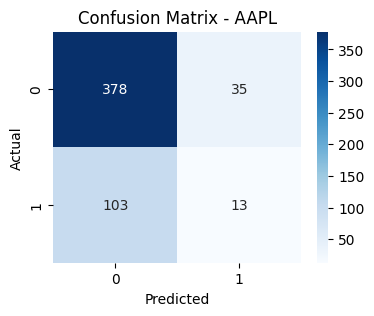


Saved models for AAPL:
['AAPL_ensemble_weights.pkl', 'AAPL_xgb_model.pkl', 'AAPL_scaler.pkl', 'AAPL_rf_model.pkl', 'AAPL_lstm_model.keras']

 TRAINING MODEL FOR: MSFT
✔ Loaded 2693 rows for MSFT from /content/drive/MyDrive/data/MSFT.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1256  329], Test: [437  92]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.664 (66.4%)
  XGB: 0.660 (66.0%)
  LSTM: 0.728 (72.8%)
Ensemble Weights: RF=0.324, XGB=0.322, LSTM=0.355

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.732 (73.2%)
  F1-Score: 0.253

 EVALUATION FOR MSFT

Accuracy:  0.7316
F1-Score:  0.2526
Precision: 0.2449
Recall:    0.2609
AUC-ROC:   0.5458

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       437
           1       0.24      0.26      0.25        92

    accuracy                           0.73       529
   macro avg       0.54      0

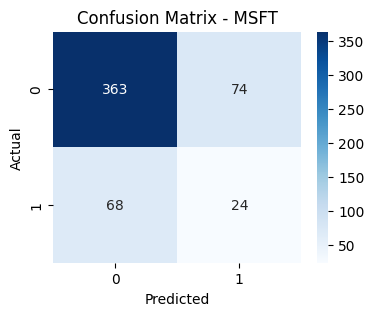


Saved models for MSFT:
['MSFT_lstm_model.keras', 'MSFT_rf_model.pkl', 'MSFT_scaler.pkl', 'MSFT_ensemble_weights.pkl', 'MSFT_xgb_model.pkl']

 TRAINING MODEL FOR: GOOGL
✔ Loaded 2693 rows for GOOGL from /content/drive/MyDrive/data/GOOGL.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1239  346], Test: [355 174]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation Accuracies:
  RF: 0.620 (62.0%)
  XGB: 0.626 (62.6%)
  LSTM: 0.720 (72.0%)
Ensemble Weights: RF=0.315, XGB=0.318, LSTM=0.366

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.647 (64.7%)
  F1-Score: 0.122

 EVALUATION FOR GOOGL

Accuracy:  0.6465
F1-Score:  0.1221
Precision: 0.3333
Recall:    0.0747
AUC-ROC:   0.5007

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       355
           1       0.33      0.07      0.12       174

    accuracy                           0.65       529
   macro avg       0.50   

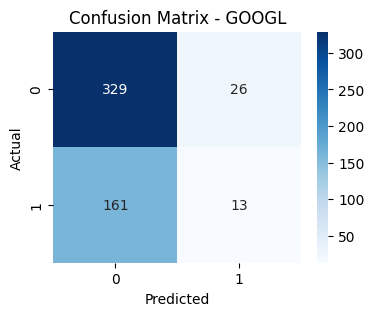


Saved models for GOOGL:
['GOOGL_scaler.pkl', 'GOOGL_xgb_model.pkl', 'GOOGL_lstm_model.keras', 'GOOGL_rf_model.pkl', 'GOOGL_ensemble_weights.pkl']

 TRAINING MODEL FOR: TSLA
✔ Loaded 2693 rows for TSLA from /content/drive/MyDrive/data/TSLA.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [999 586], Test: [343 186]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.599 (59.9%)
  XGB: 0.590 (59.0%)
  LSTM: 0.603 (60.3%)
Ensemble Weights: RF=0.334, XGB=0.329, LSTM=0.336

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.586 (58.6%)
  F1-Score: 0.282

 EVALUATION FOR TSLA

Accuracy:  0.5860
F1-Score:  0.2820
Precision: 0.3613
Recall:    0.2312
AUC-ROC:   0.5048

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       343
           1       0.36      0.23      0.28       186

    accuracy                           0.59       529
   macro avg       0.51   

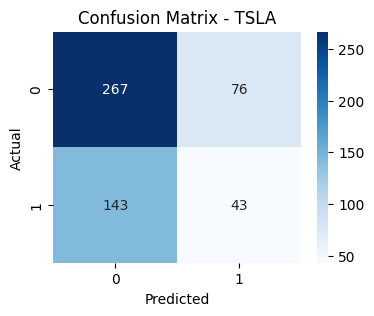


Saved models for TSLA:
['TSLA_xgb_model.pkl', 'TSLA_scaler.pkl', 'TSLA_ensemble_weights.pkl', 'TSLA_lstm_model.keras', 'TSLA_rf_model.pkl']

 TRAINING MODEL FOR: META
✔ Loaded 2693 rows for META from /content/drive/MyDrive/data/META.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1173  412], Test: [356 173]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation Accuracies:
  RF: 0.614 (61.4%)
  XGB: 0.588 (58.8%)
  LSTM: 0.684 (68.4%)
Ensemble Weights: RF=0.326, XGB=0.312, LSTM=0.363

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.654 (65.4%)
  F1-Score: 0.179

 EVALUATION FOR META

Accuracy:  0.6541
F1-Score:  0.1794
Precision: 0.4000
Recall:    0.1156
AUC-ROC:   0.5157

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       356
           1       0.40      0.12      0.18       173

    accuracy                           0.65       529
   macro avg       0.54      0

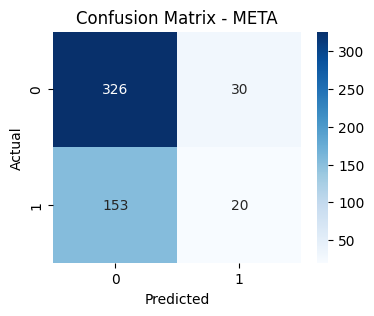


Saved models for META:
['META_scaler.pkl', 'META_ensemble_weights.pkl', 'META_xgb_model.pkl', 'META_lstm_model.keras', 'META_rf_model.pkl']

 TRAINING MODEL FOR: ADBE
✔ Loaded 2693 rows for ADBE from /content/drive/MyDrive/data/ADBE.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1178  407], Test: [401 128]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.533 (53.3%)
  XGB: 0.563 (56.3%)
  LSTM: 0.696 (69.6%)
Ensemble Weights: RF=0.297, XGB=0.314, LSTM=0.388

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.595 (59.5%)
  F1-Score: 0.301

 EVALUATION FOR ADBE

Accuracy:  0.5955
F1-Score:  0.3007
Precision: 0.2584
Recall:    0.3594
AUC-ROC:   0.5151

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       401
           1       0.26      0.36      0.30       128

    accuracy                           0.60       529
   macro avg       0.51      0

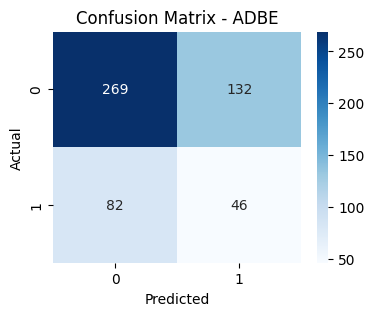


Saved models for ADBE:
['ADBE_xgb_model.pkl', 'ADBE_lstm_model.keras', 'ADBE_ensemble_weights.pkl', 'ADBE_scaler.pkl', 'ADBE_rf_model.pkl']

 TRAINING MODEL FOR: AMZN
✔ Loaded 2693 rows for AMZN from /content/drive/MyDrive/data/AMZN.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1166  419], Test: [389 140]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.645 (64.5%)
  XGB: 0.645 (64.5%)
  LSTM: 0.707 (70.7%)
Ensemble Weights: RF=0.323, XGB=0.323, LSTM=0.354

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.688 (68.8%)
  F1-Score: 0.247

 EVALUATION FOR AMZN

Accuracy:  0.6881
F1-Score:  0.2466
Precision: 0.3418
Recall:    0.1929
AUC-ROC:   0.5296

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       389
           1       0.34      0.19      0.25       140

    accuracy                           0.69       529
   macro avg       0.55      0

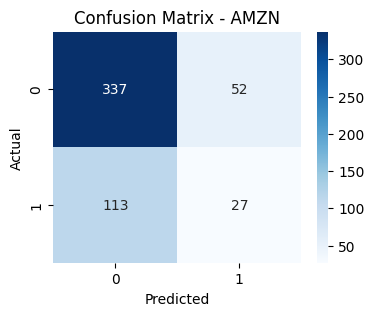


Saved models for AMZN:
['AMZN_rf_model.pkl', 'AMZN_xgb_model.pkl', 'AMZN_ensemble_weights.pkl', 'AMZN_scaler.pkl', 'AMZN_lstm_model.keras']

 TRAINING MODEL FOR: NVDA
✔ Loaded 2693 rows for NVDA from /content/drive/MyDrive/data/NVDA.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [998 587], Test: [313 216]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.507 (50.7%)
  XGB: 0.541 (54.1%)
  LSTM: 0.605 (60.5%)
Ensemble Weights: RF=0.307, XGB=0.327, LSTM=0.366

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.527 (52.7%)
  F1-Score: 0.362

 EVALUATION FOR NVDA

Accuracy:  0.5274
F1-Score:  0.3622
Precision: 0.4034
Recall:    0.3287
AUC-ROC:   0.4966

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       313
           1       0.40      0.33      0.36       216

    accuracy                           0.53       529
   macro avg       0.50      0.5

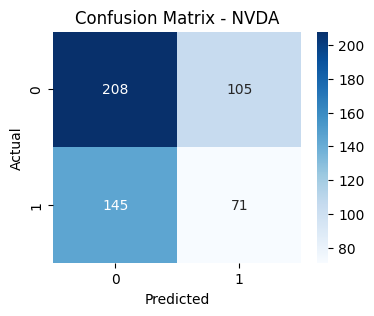


Saved models for NVDA:
['NVDA_xgb_model.pkl', 'NVDA_rf_model.pkl', 'NVDA_scaler.pkl', 'NVDA_ensemble_weights.pkl', 'NVDA_lstm_model.keras']

 TRAINING MODEL FOR: NFLX
✔ Loaded 2693 rows for NFLX from /content/drive/MyDrive/data/NFLX.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1083  502], Test: [370 159]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.620 (62.0%)
  XGB: 0.595 (59.5%)
  LSTM: 0.675 (67.5%)
Ensemble Weights: RF=0.328, XGB=0.315, LSTM=0.357

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.681 (68.1%)
  F1-Score: 0.133

 EVALUATION FOR NFLX

Accuracy:  0.6805
F1-Score:  0.1333
Precision: 0.3611
Recall:    0.0818
AUC-ROC:   0.5098

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       370
           1       0.36      0.08      0.13       159

    accuracy                           0.68       529
   macro avg       0.53      0

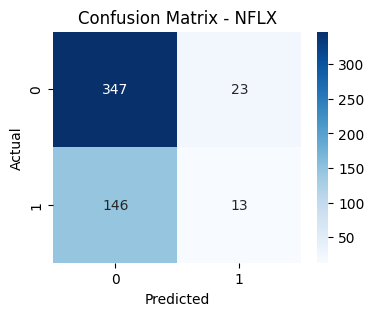


Saved models for NFLX:
['NFLX_ensemble_weights.pkl', 'NFLX_rf_model.pkl', 'NFLX_lstm_model.keras', 'NFLX_scaler.pkl', 'NFLX_xgb_model.pkl']

 TRAINING MODEL FOR: INTC
✔ Loaded 2693 rows for INTC from /content/drive/MyDrive/data/INTC.csv
Train: 1585, Val: 529, Test: 529
Target distribution - Train: [1228  357], Test: [383 146]
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracies:
  RF: 0.669 (66.9%)
  XGB: 0.662 (66.2%)
  LSTM: 0.728 (72.8%)
Ensemble Weights: RF=0.325, XGB=0.321, LSTM=0.354

 FINAL ENSEMBLE RESULTS:
  Accuracy: 0.673 (67.3%)
  F1-Score: 0.139

 EVALUATION FOR INTC

Accuracy:  0.6730
F1-Score:  0.1393
Precision: 0.2545
Recall:    0.0959
AUC-ROC:   0.4944

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       383
           1       0.25      0.10      0.14       146

    accuracy                           0.67       529
   macro avg       0.49      0

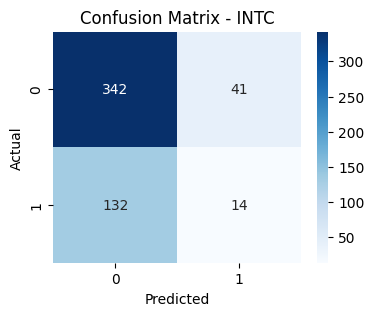


Saved models for INTC:
['INTC_rf_model.pkl', 'INTC_scaler.pkl', 'INTC_ensemble_weights.pkl', 'INTC_lstm_model.keras', 'INTC_xgb_model.pkl']


In [ ]:
import os

stock_list = ["AAPL", "MSFT", "GOOGL", "TSLA","META","ADBE","AMZN","NVDA","NFLX","INTC"]

results_summary = []

for stock in stock_list:
    print("\n====================================")
    print(f" TRAINING MODEL FOR: {stock}")
    print("====================================")

    df = load_stock_data(stock)
    df_advanced, features = create_advanced_features(df)

    if len(df_advanced) < 500:
        print(f"Skipping {stock} — not enough data.")
        continue

    X = df_advanced[features]
    y = df_advanced["Target_3d_Strong"]  # choose your target

    # Train model
    results = train_weighted_ensemble(X, y, stock_name=stock)

    # Evaluate model
    metrics = evaluate_model(
        stock_name=stock,
        y_test=results["y_test"],
        ensemble_pred=results["ensemble_binary"],    # binary pred used as ordinary pred
        ensemble_binary=results["ensemble_binary"]
    )

    # Store summary
    results_summary.append({
        "stock": stock,
        "accuracy": metrics["accuracy"],
        "f1": metrics["f1"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "auc": metrics["auc"]
    })

    # Show saved files
    print(f"\nSaved models for {stock}:")
    print(os.listdir(f"saved_models/{stock}"))


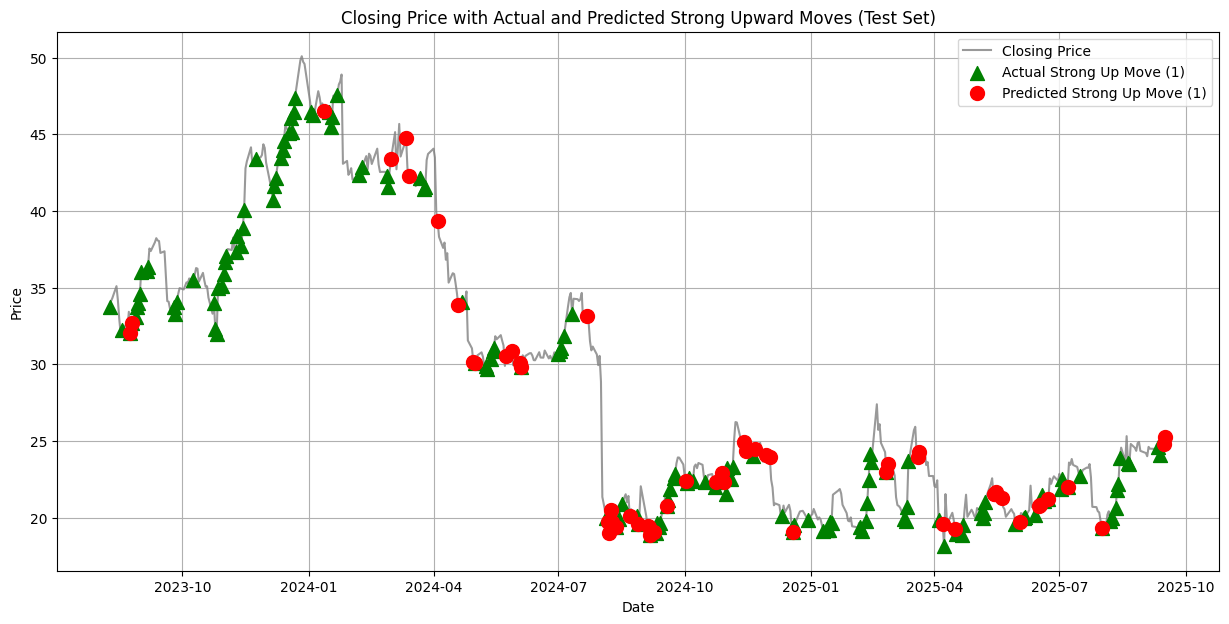

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results' and 'df_advanced' from previous executions are available

if 'y_test' in results and 'ensemble_binary' in results and 'df_advanced' in locals():
    y_test_actual = results['y_test']
    ensemble_binary_predictions = results['ensemble_binary']

    # Get the corresponding dates and closing prices for the test set
    train_idx = int(0.6 * len(df_advanced))
    val_idx = int(0.8 * len(df_advanced))
    test_df = df_advanced.iloc[val_idx:].copy() # Get the test slice of the dataframe
    test_dates = test_df.index
    test_close_prices = test_df['Close']


    plt.figure(figsize=(15, 7))

    # Plot the closing price
    plt.plot(test_dates, test_close_prices, label='Closing Price', color='gray', alpha=0.8)

    # Highlight actual positive moves
    actual_positive_dates = test_dates[y_test_actual == 1]
    actual_positive_prices = test_close_prices[y_test_actual == 1]
    plt.scatter(actual_positive_dates, actual_positive_prices, color='green', marker='^', s=100, label='Actual Strong Up Move (1)', zorder=5)

    # Highlight predicted positive moves
    predicted_positive_dates = test_dates[ensemble_binary_predictions == 1]
    predicted_positive_prices = test_close_prices[ensemble_binary_predictions == 1]
    plt.scatter(predicted_positive_dates, predicted_positive_prices, color='red', marker='o', s=100, label='Predicted Strong Up Move (1)', zorder=5)


    plt.title('Closing Price with Actual and Predicted Strong Upward Moves (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Required data ('results' or 'df_advanced') not found. Please run the training and feature creation cells first.")

In [ ]:
# ===========================================================
#   FIXED HYBRID PREDICT FUNCTION (handles split & validation)
# ===========================================================

import joblib
import numpy as np
import pandas as pd
from datetime import timedelta
from tensorflow.keras.models import load_model
import yfinance as yf

def adjust_for_split(csv_price, yahoo_price):
    """

    """
    ratio = csv_price / yahoo_price

    # Detect 10:1 split
    if 8 < ratio < 12:
        return yahoo_price * 10

    # Detect 4:1 split
    if 3 < ratio < 5:
        return yahoo_price * 4

    # No split
    return yahoo_price


def hybrid_predict(stock, create_fn):
    print(f"\n======== PREDICTING: {stock} ========\n")

    # ---- Load stock CSV ----
    df = load_stock_data(stock)
    if df.empty:
        print(" Data not found!")
        return None

    print(f"✔ Loaded {len(df)} rows for {stock}")

    # ---- Recreate features ----
    df_advanced, features = create_fn(df)

    if len(df_advanced) < 2:
        print("Not enough feature rows to predict.")
        return None

    X = df_advanced[features]
    last_row = X.iloc[-1:].values

    # ---- Load saved model files ----
    base_path = f"/content/saved_models/{stock}"

    try:
        rf = joblib.load(f"{base_path}/{stock}_rf_model.pkl")
        xgb = joblib.load(f"{base_path}/{stock}_xgb_model.pkl")
        scaler = joblib.load(f"{base_path}/{stock}_scaler.pkl")
        weights = joblib.load(f"{base_path}/{stock}_ensemble_weights.pkl")
        lstm = load_model(f"{base_path}/{stock}_lstm_model.keras")
    except Exception as e:
        print("Model files missing or incorrect path!")
        print(e)
        return None

    # ---- Scaling ----
    X_scaled = scaler.transform(last_row)

    # ---- LSTM reshape ----
    X_lstm = X_scaled.reshape(1, 1, X_scaled.shape[1])

    # ---- Individual model predictions ----
    rf_p = rf.predict_proba(X_scaled)[0][1]
    xgb_p = xgb.predict_proba(X_scaled)[0][1]
    lstm_p = float(lstm.predict(X_lstm, verbose=0)[0])

    # ---- Weighted ensemble ----
    ensemble_prob = (
        weights["rf"] * rf_p +
        weights["xgb"] * xgb_p +
        weights["lstm"] * lstm_p
    )

    # ---- Direction ----
    direction = "UP" if ensemble_prob > 0.5 else "DOWN"
    print(f"Ensemble Probability: {ensemble_prob:.4f}")
    print(f"Predicted Direction: {direction}")

    # ---- Last Close Price ----
    last_price = float(df["Close"].iloc[-1])
    print(f"Last Close Price: ${last_price:.2f}")

    # ---- Convert probability → predicted price ----
    predicted_return = (ensemble_prob - 0.5) * 0.02   # ±2%
    predicted_price = last_price * (1 + predicted_return)

    print(f"Predicted Price: ${predicted_price:.2f}")

    # ===================================================
    #          VALIDATION USING YAHOO FINANCE
    # ===================================================
    print("\n---- VALIDATION ----")

    last_date = df.index[-1]

    # find next valid trading day
    next_day = last_date + timedelta(days=1)
    while next_day.weekday() >= 5:   # skip Saturday/Sunday
        next_day += timedelta(days=1)

    # fetch actual next-day price (unadjusted)
    data = yf.download(
        stock,
        start=next_day,
        end=next_day + timedelta(days=1),
        auto_adjust=False     # SUPER important!!
    )

    if data.empty:
        print("⚠ Next-day market data not available yet.")
        return None

    yahoo_raw_price = float(data["Close"].iloc[0])
    actual_price = adjust_for_split(last_price, yahoo_raw_price)

    # compute errors
    error = predicted_price - actual_price
    pct_error = abs(error / actual_price) * 100
    actual_direction = "UP" if actual_price > last_price else "DOWN"

    print(f"Actual Price: ${actual_price:.2f}")
    print(f"Absolute Error: {error:.4f}")
    print(f"Percentage Error: {pct_error:.2f}%")
    print(f"Actual Direction: {actual_direction}")
    print(f"Prediction Correct: {actual_direction == direction}")

    return {
        "probability": ensemble_prob,
        "direction": direction,
        "predicted_price": predicted_price,
        "last_price": last_price,
        "actual_price": actual_price,
        "pct_error": pct_error
    }


In [ ]:
result = hybrid_predict("AAPL", create_advanced_features)


======== PREDICTING: AAPL ========

✔ Loaded 2693 rows for AAPL from /content/drive/MyDrive/data/AAPL.csv
✔ Loaded 2693 rows for AAPL
Ensemble Probability: 0.2786
Predicted Direction: DOWN
Last Close Price: $238.99
Predicted Price: $237.93

---- VALIDATION ----


[*********************100%***********************]  1 of 1 completed

Actual Price: $237.88
Absolute Error: 0.0516
Percentage Error: 0.02%
Actual Direction: DOWN
Prediction Correct: True
